Using TensorFlow backend.


Loading model from sample_epoch20True


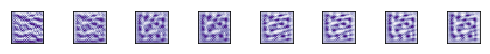

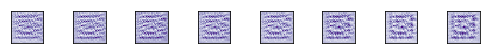

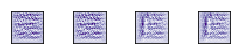

In [1]:
# Build visualization filters for CNN model
import os
import sys
import struct
import argparse
from keras.models import load_model
from termcolor import colored, cprint
import keras.backend as K
from keras.utils import *
import numpy as np
import matplotlib.pyplot as plt

nb_ckass = 7
LR_RATE = 2e-2
NUM_STEPS = 200
RECORD_FREQ = 10
NUM_RECORD = int(NUM_STEPS/RECORD_FREQ)

 ######## Build folder for loading and saving analysis images. ######## 
model_name = 'MNIST_model_fixed_20180118'
base_dir = 'C:/Users/User/Raw data/CNN_test'

img_dir = os.path.join(base_dir, 'image')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
img_name_dir = os.path.join(img_dir, model_name)
if not os.path.exists(img_name_dir):
    os.makedirs(img_name_dir)
vis_dir = os.path.join(img_name_dir, 'vis_layers')
if not os.path.exists(vis_dir):
    os.makedirs(vis_dir)
filter_dir = os.path.join(img_name_dir, 'filters_dir')
if not os.path.exists(filter_dir):
    os.makedirs(filter_dir)

mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

 ######## Define tool function ######## 
def normalize(x):
    return x /(K.sqrt(K.mean(K.square(x))) + 1e-8)

def grad_ascent(num_step, input_image_data, iter_func):
    for i in range(num_step):
        loss_value, grads_value = iter_func([input_img_data])
        input_img_data += grads_value * LR_RATE
    return input_img_data

def readfile():
    with open(base_dir + '/datasets/MNIST/train-images.idx3-ubyte','rb') as f1:
        buf1 = f1.read()
    with open(base_dir + '/datasets/MNIST/train-labels.idx1-ubyte','rb') as f2:
        buf2 = f2.read()
    return buf1, buf2

def get_image(buf1, num):
    image_index = 0
    image_index += struct.calcsize('>IIII')
    im = []
    for i in range(num):
        temp = struct.unpack_from('>784B', buf1, image_index) # '>784B'的意思就是用大端法读取784个unsigned byte
        im.append(np.reshape(temp,(28,28)))
        image_index += struct.calcsize('>784B')  # 每次增加784B
    return im

def get_label(buf2, num): # 得到标签数据
    label_index = 0
    label_index += struct.calcsize('>II')
    return struct.unpack_from('>{}B'.format(num), buf2, label_index)

 ######## Build and run visualization filters ######## 
def visFilter():
    model = 'sample'
    epoch = 20
    mode = 0
    batch = 128
    idx = True
    num = 10000
    choose_start = 0
    choose_end = 9
    
    store_path = '{}_epoch{}{}'.format(model, epoch, idx)
    print(colored('Loading model from {}'.format(store_path), 'yellow', attrs=['bold']))
    model_path = os.path.join(model_dir, 'model-{}.h5'.format(epoch))
    emotion_model = load_model(model_path)
    
    layer_dict = dict([layer.name, layer] for layer in emotion_model.layers[1:])
    
    input_img = emotion_model.input
    #name_lys = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']
    name_lys = ['conv2d_4', 'conv2d_5', 'conv2d_6']
    #name_ls = ['zero_padding2d_4']
    if mode == 1:
        collect_layers = list()
        for name_ly in name_lys:
            collect_layers.append(K.function([input_img, K.learning_phase()], 
                                             [layer_dict[name_ly].output]))
        
        image_data, label_data = readfile()
        dev_feat = get_image(image_data, num)
        dev_label = get_label(label_data, num)
        for choose_id in range(choose_start, choose_end):
            photo = dev_feat[choose_id]
            for cnt, fn in enumerate(collect_layers):
                im = fn([photo.reshape(1, 28, 28, 1), 0])
                im_dim = im[0].ndim
                nb_filter = im[0].shape[im_dim - 1]
                fig = plt.figure(figsize=(14, 8))
                for i in range(nb_filter):
                    ax = fig.add_subplot(nb_filter/16, 16, i+1)
                    ax.imshow(im[0][0,:,:,i], cmap='Purples')
                    plt.xticks(np.array([]))
                    plt.yticks(np.array([]))
                    plt.tight_layout()
                fig.suptitle('Output of layer{} (Given image{})'.format(cnt, choose_id))
                img_path = os.path.join(vis_dir, '{}-image{}'.format(store_path, choose_id))
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
                fig.savefig(os.path.join(img_path, 'layer{}'.format(cnt)))
                plt.show()
    else:
        collect_layers = list()
        for name_ly in name_lys:
            collect_layers.append(layer_dict[name_ly].output)
            
        for cnt, c in enumerate(collect_layers):
            ini_input_img = np.random.random((1, 28, 28, 1))
            nb_filter = c.shape[-1]
            filter_imgs = [ini_input_img for i in range(nb_filter)]
            fig = plt.figure(figsize=(14,8))
            for filter_idx in range(nb_filter):
                loss = c[:,:,:,filter_idx]
                grads = normalize(K.gradients(loss, input_img)[0])
                iterate = K.function([input_img], [loss, grads])
                
                for i in range(NUM_STEPS):
                    loss_value, grads_value = iterate([filter_imgs[filter_idx]])
                    filter_imgs[filter_idx] += grads_value * LR_RATE
                    
                filter_img = np.reshape(filter_imgs[filter_idx], (28,28))
                ax = fig.add_subplot(NUM_STEPS/16, 16, filter_idx+1)
                ax.imshow(filter_img, cmap='Purples')
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
                plt.tight_layout()
                #plt.xlabel('{:.3f}'.format(filter_imgs[it][i][1]))
            #fig.suptitle('Filters of {}'.format(name_lys[cnt]))
            img_path = os.path.join(filter_dir, '{}-{}'.format(store_path, name_lys[cnt]))
            if not os.path.isdir(img_path):
                os.mkdir(img_path)
            fig.savefig(os.path.join(img_path, name_lys[cnt]))
            plt.show()
            
visFilter()